In [11]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import random_split

In [12]:
data_dir = "C:/Users/user/OneDrive/Masaüstü/malware_images"

# Define transformations for your images (adjust as needed)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Resize for EfficientNet-B3
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the ImageFolder dataset
dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

# Define the validation set split ratio (e.g., 20% for validation)
val_split = 0.2

# Split the dataset into train and validation sets using random_split
train_size = int(len(dataset) * (1 - val_split))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

image_datasets = {
    'train': train_data,
    'val': val_data,
}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = dataset.classes

# ... rest of your transfer learning code using train_loader and val_loader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

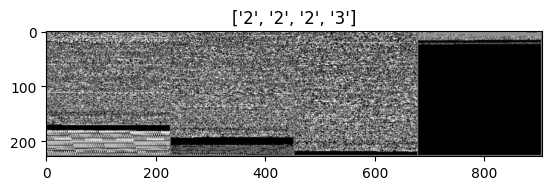

In [13]:
def imshow(inp, title=None):
    #Display image for Tensor
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
model_ft = models.efficientnet_b3(weights='IMAGENET1K_V1')
num_ftrs =  model_ft.classifier[1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 9)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3219 Acc: 0.5947
val Loss: 0.8725 Acc: 0.7125

Epoch 1/24
----------
train Loss: 0.8348 Acc: 0.7189
val Loss: 0.6419 Acc: 0.8045

Epoch 2/24
----------
train Loss: 0.7257 Acc: 0.7549
val Loss: 0.5399 Acc: 0.8298

Epoch 3/24
----------
train Loss: 0.6282 Acc: 0.7863
val Loss: 0.5476 Acc: 0.8257

Epoch 4/24
----------
train Loss: 0.5692 Acc: 0.8061
val Loss: 0.5376 Acc: 0.8376

Epoch 5/24
----------
train Loss: 0.5305 Acc: 0.8183
val Loss: 0.4494 Acc: 0.8569

Epoch 6/24
----------
train Loss: 0.4929 Acc: 0.8328
val Loss: 0.4747 Acc: 0.8500

Epoch 7/24
----------
train Loss: 0.4574 Acc: 0.8436
val Loss: 0.3909 Acc: 0.8675

Epoch 8/24
----------
train Loss: 0.4464 Acc: 0.8490
val Loss: 0.3862 Acc: 0.8721

Epoch 9/24
----------
train Loss: 0.4312 Acc: 0.8515
val Loss: 0.4548 Acc: 0.8367

Epoch 10/24
----------
train Loss: 0.4285 Acc: 0.8536
val Loss: 0.4131 Acc: 0.8657

Epoch 11/24
----------
train Loss: 0.4254 Acc: 0.8525
val Loss: 0.4366 Acc: 0.8528

Ep

In [19]:
torch.save(model_ft.state_dict(), "C:/Users/user/Documents/malware.pt") #0.88 Acc 

In [20]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

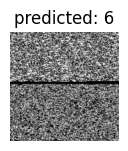

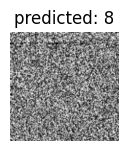

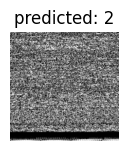

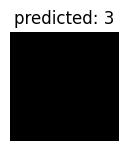

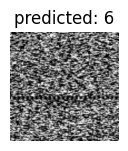

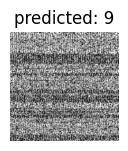

In [21]:
visualize_model(model_ft)

In [25]:
model_ft.load_state_dict(torch.load("C:/Users/user/Documents/malware.pt")) #documentse kaydet 

<All keys matched successfully>

In [24]:
#Malware Microsoft Challenge Test
"""
test_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_data = datasets.ImageFolder("C:/Users/user/OneDrive/Masaüstü/test_images", transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 16, num_workers = 0)
"""

'\ntest_transform = transforms.Compose([\n    transforms.RandomResizedCrop(224),\n    transforms.ToTensor(),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])\ntest_data = datasets.ImageFolder("C:/Users/user/OneDrive/Masaüstü/test_images", transform=test_transform)\ntest_loader = torch.utils.data.DataLoader(test_data, batch_size = 16, num_workers = 0)\n'

In [ ]:
"""
classes_img = ('1', '2', '3', '4', '5', '6', '7', '8', '9')
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{str(classes_img[labels[j]]):5s}' for j in range(4)))
""" 

In [ ]:
"""
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model_ft(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the ferplus test images: {100 * correct // total} %')
""" 